In [1]:
from hiive.mdptoolbox import example,mdp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import random
import math
import time as time

In [2]:
plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=10) #fontsize of the title
plt.rc('axes', labelsize=10) #fontsize of the x and y labels
plt.rc('xtick', labelsize=8) #fontsize of the x tick labels
plt.rc('ytick', labelsize=8) #fontsize of the y tick labels
plt.rc('legend', fontsize=8) #fontsize of the legend
plt.rc('figure',figsize = (3, 3),dpi=300)
plt.rc('savefig',dpi=300)
plt.rc('lines',markersize=2)


In [167]:
def plot_policy_value(q,title=None):

    fig,ax=plt.subplots()

    ax.scatter(range(q.S),q.V,zorder=-1,label="Wait")
    cut_times=[i for i,p in enumerate(q.policy) if p]

    ax.scatter(cut_times,[q.V[i] for i in cut_times],c="black",zorder=1,label="Cut")

    ax.legend(loc='best',title="Policy",title_fontsize=8,handletextpad=0)

    ax.set_xlabel("Forest age")
    ax.set_ylabel("Value")

    if title:
        ax.set_title(title)
    
    plt.show()


In [168]:
class MyQLearning(mdp.QLearning):
    def run(self,plot=False,plot_freq=1000,episode_length=100):
        # Run the Q-learning algorithm.
 
        self.run_stats = []


        self.time = time.time()
        self.episode_end=[]
        # initial state choice
        s = np.random.randint(self.S)
        reset_s = False
        run_stats = []

        self.reward_per_episode=[0]
        self.error_per_episode=[0]
        self.episode_mean_Q=[]
        last_episode_end=0
        current_episode=1
        self.converged=False
        for n in range(1, self.max_iter + 1):

            # Reinitialisation of trajectories every 100 transitions
            if (n%episode_length==0):
                if (self.error_per_episode[-1]<1e-3):
                    self.converged=True
                self.episode_mean_Q.append(np.mean(self.Q))
                self.episode_end.append(n-1)
                self.error_per_episode.append(0)
                self.reward_per_episode.append(0)
                
                if (((current_episode%plot_freq)==0 or self.converged) and plot):
                    plot_policy_value(self,f"Q-Learning on Forest ({current_episode} Episodes)")
                if self.converged:
                    break
                current_episode+=1

                s = np.random.randint(self.S)



            # Action choice : greedy with increasing probability
            # The agent takes random actions for probability ε and greedy action for probability (1-ε).
            pn = np.random.random()
            if pn < self.epsilon:
                a = np.random.randint(0, self.A)
            else:
                # optimal_action = self.Q[s, :].max()
                a = self.Q[s, :].argmax()

            # Simulating next state s_new and reward associated to <s,s_new,a>
            p_s_new = np.random.random()
            p = 0
            s_new = -1
            while (p < p_s_new) and (s_new < (self.S - 1)):
                s_new = s_new + 1
                p = p + self.P[a][s, s_new]

            try:
                r = self.R[a][s, s_new]
            except IndexError:
                try:
                    r = self.R[s, a]
                except IndexError:
                    r = self.R[s]

            # Q[s, a] = Q[s, a] + alpha*(R + gamma*Max[Q(s’, A)] - Q[s, a])
            # Updating the value of Q

            dQ = self.alpha * (r + self.gamma * self.Q[s_new, :].max() - self.Q[s, a])
            self.Q[s, a] = self.Q[s, a] + dQ

            # Computing means all over maximal Q variations values
            error = np.absolute(dQ)
            self.error_per_episode[-1]+=error
            self.reward_per_episode[-1]+=r
            # compute the value function and the policy
            v = self.Q.max(axis=1)
            self.V = v
            p = self.Q.argmax(axis=1)
            self.policy = p

            self.S_freq[s,a] += 1
            run_stats.append(self._build_run_stat(i=n, s=s, a=a, r=r, p=p, v=v, error=error))


            self.run_stats.append(run_stats[-1])
            run_stats = []
            
            #plot
            
            # current state is updated
            s = s_new

            self.alpha *= self.alpha_decay
            if self.alpha < self.alpha_min:
                self.alpha = self.alpha_min

            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.epsilon_min:
                self.epsilon = self.epsilon_min

        self._endRun()
        # add stragglers

        if self.run_stats is None or len(self.run_stats) == 0:
            self.run_stats = run_stats
        return self.run_stats

In [5]:
RANDOM_STATE=29

In [6]:
P,R=example.forest(S=200, r1=4, r2=2, p=0.1, is_sparse=False)

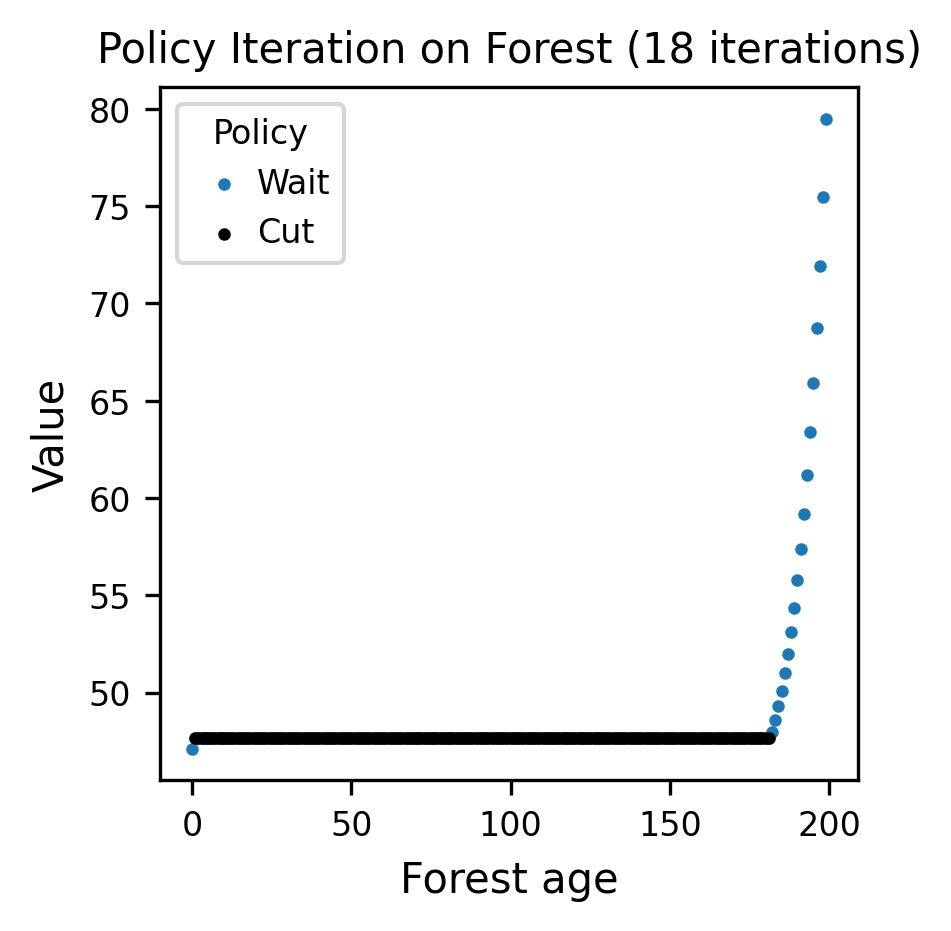

In [198]:
pi=mdp.PolicyIteration(P,R,0.99,eval_type=0,run_stat_frequency=1,policy0=None,max_iter=1000)
pi_run_stats=pi.run()


plot_policy_value(pi,f"Policy Iteration on Forest ({len(pi_run_stats)} iterations)")

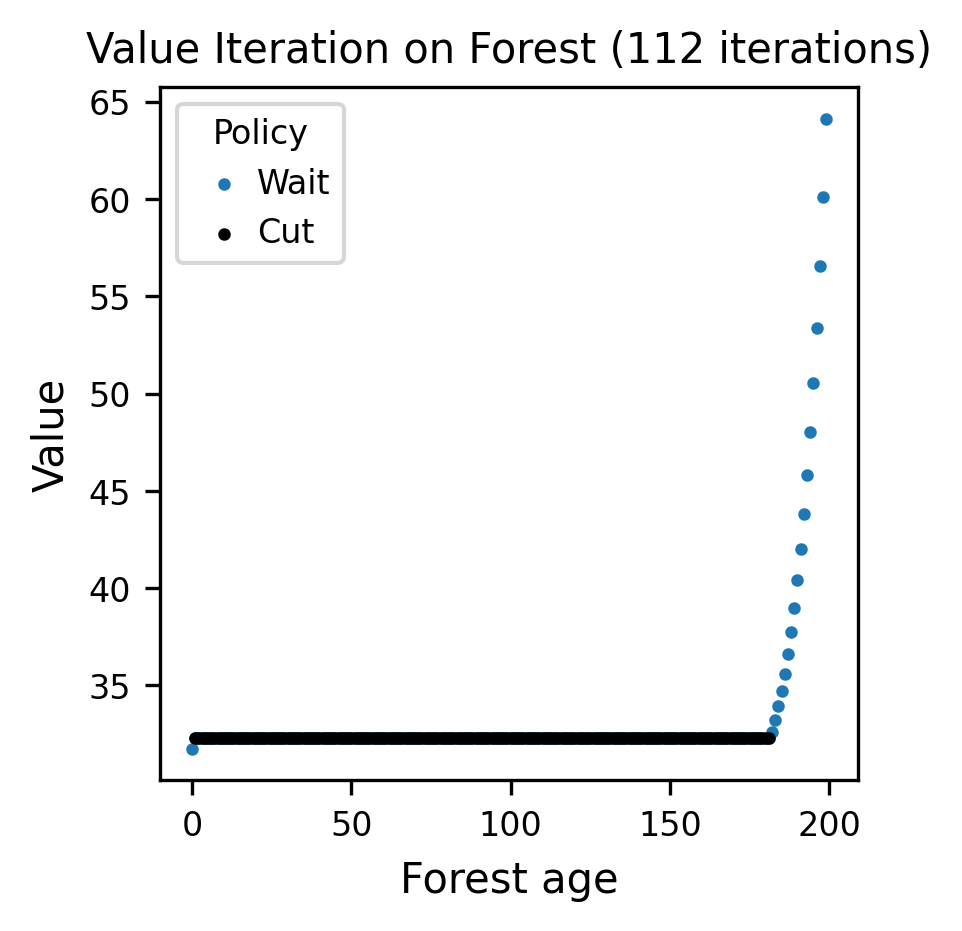

In [215]:
vi = mdp.ValueIteration(P, R, 0.99,run_stat_frequency=1,epsilon=1e-3,max_iter=100000)
vi_run_stats=vi.run()


plot_policy_value(vi,f"Value Iteration on Forest ({len(vi_run_stats)} iterations)")

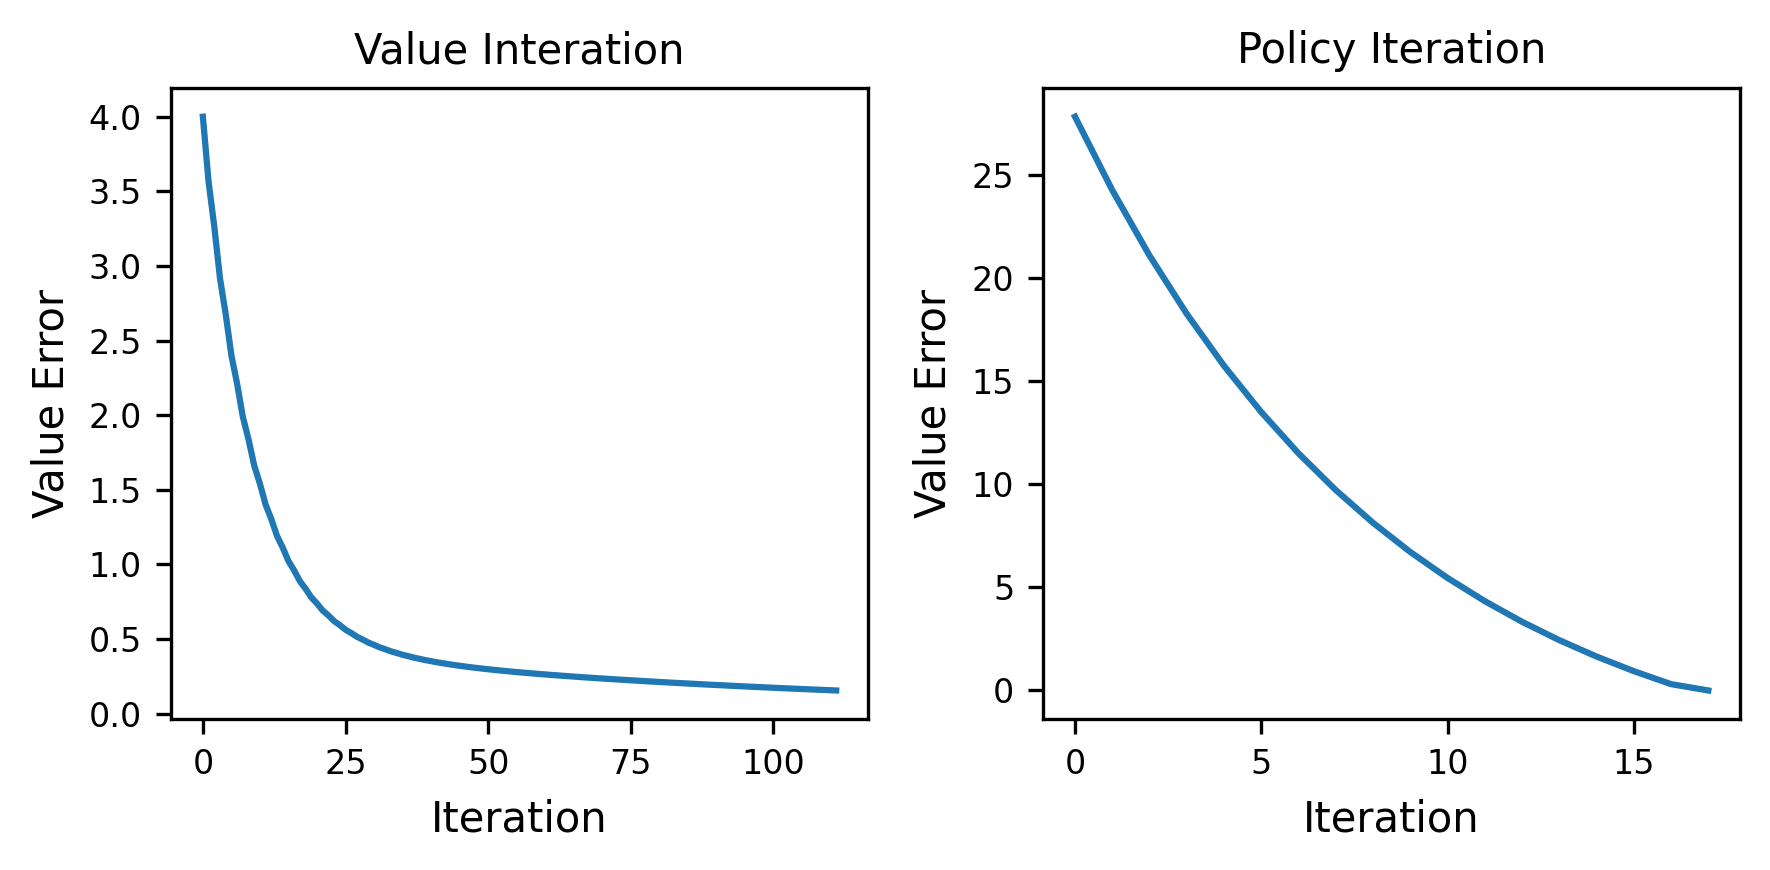

In [202]:
fig,axs=plt.subplots(1,2,figsize=(6,3))

for ax,run_stats,title in zip(axs,(vi_run_stats,pi_run_stats),['Value Interation','Policy Iteration']):
    ax.plot([i['Error'] for i in run_stats])
    ax.set_title(title)
    ax.set_ylabel("Value Error")
    ax.set_xlabel("Iteration")
plt.tight_layout()

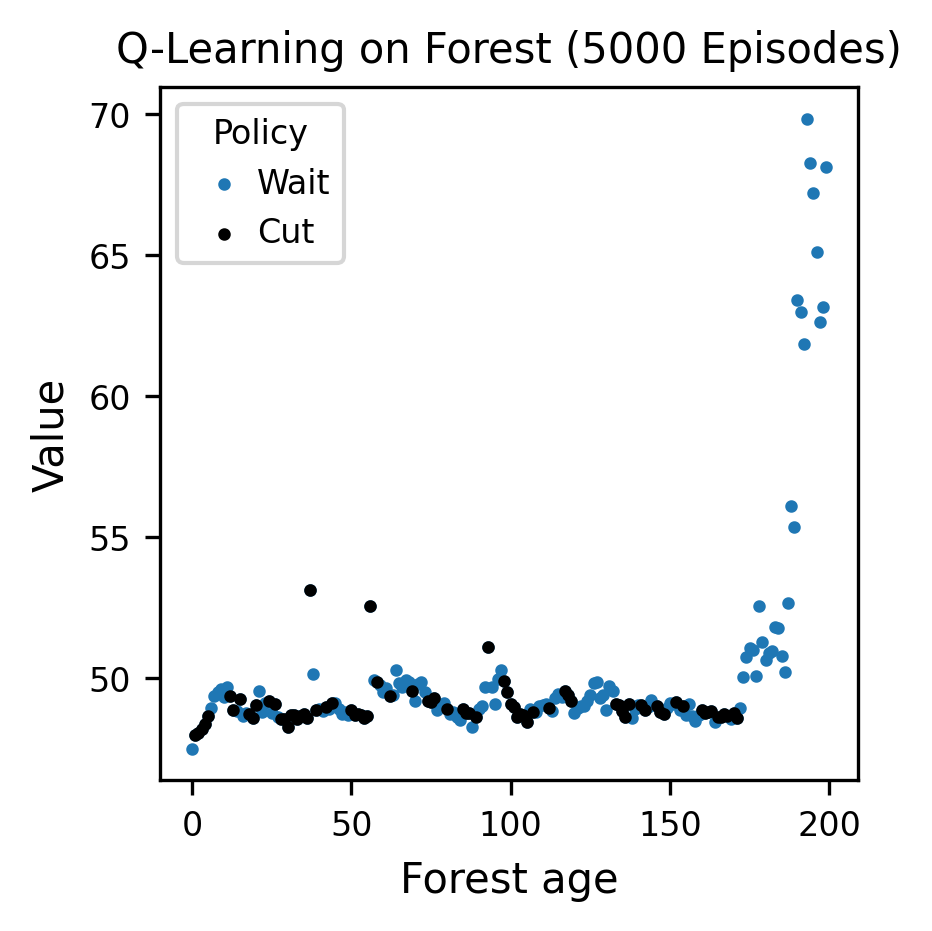

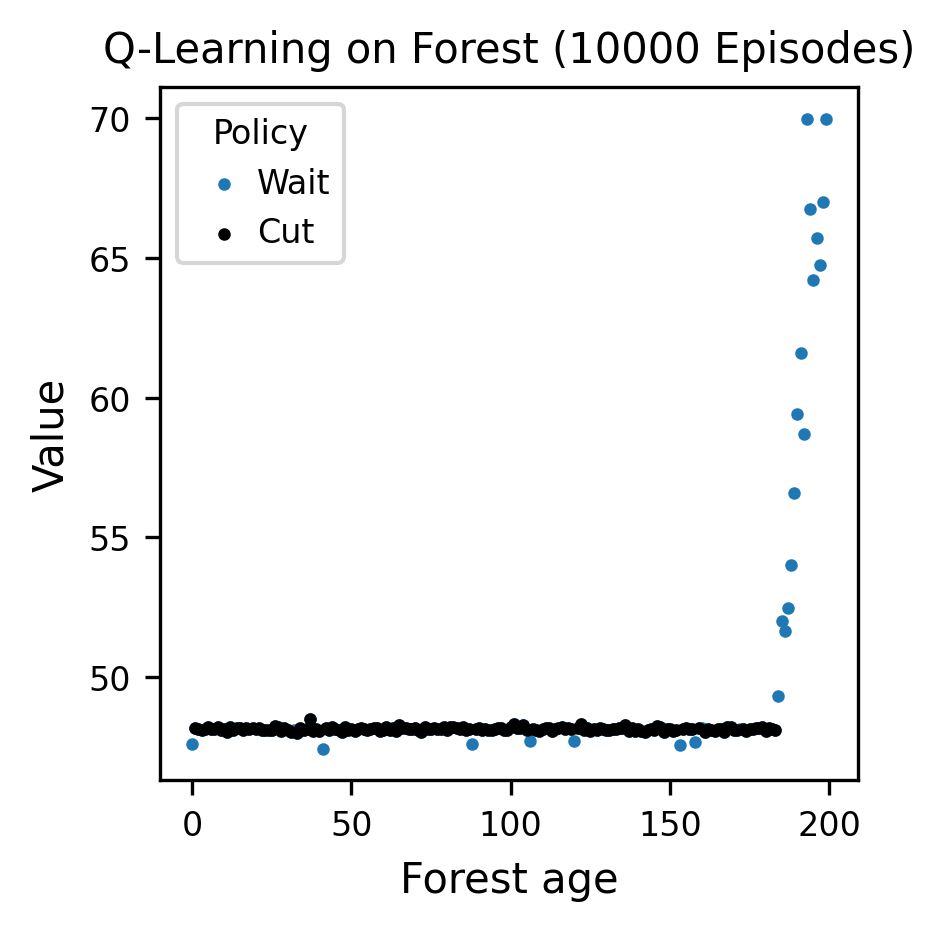

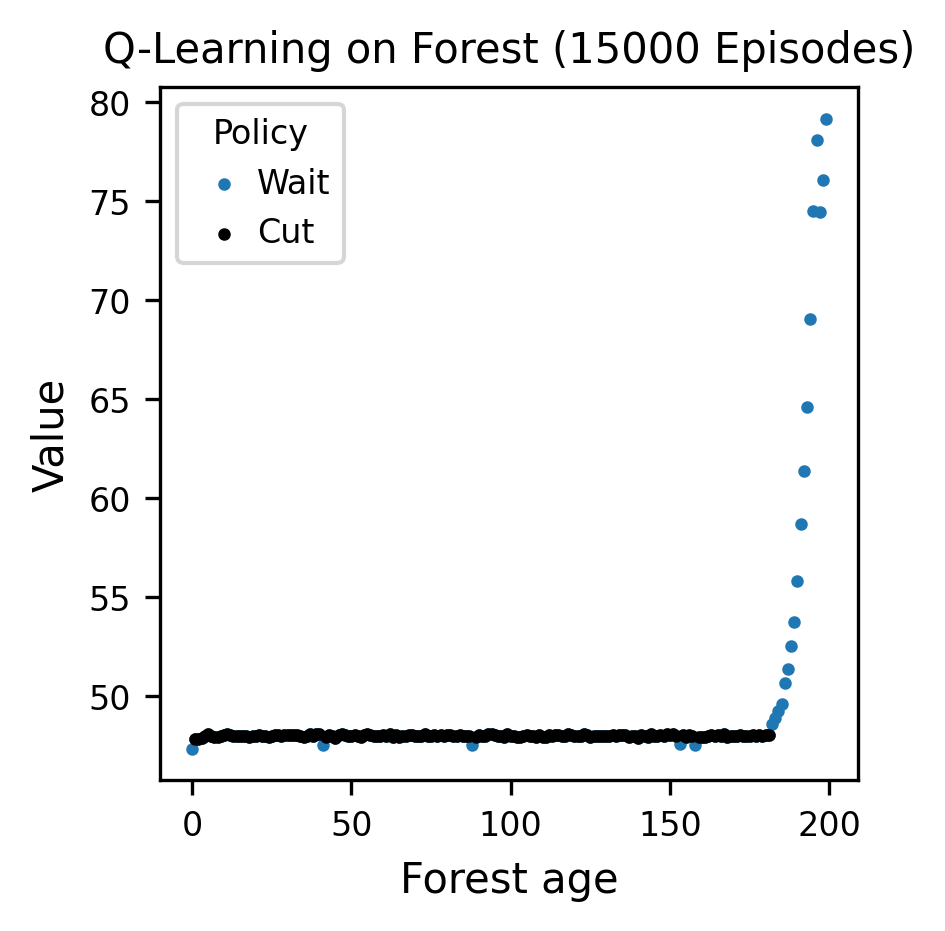

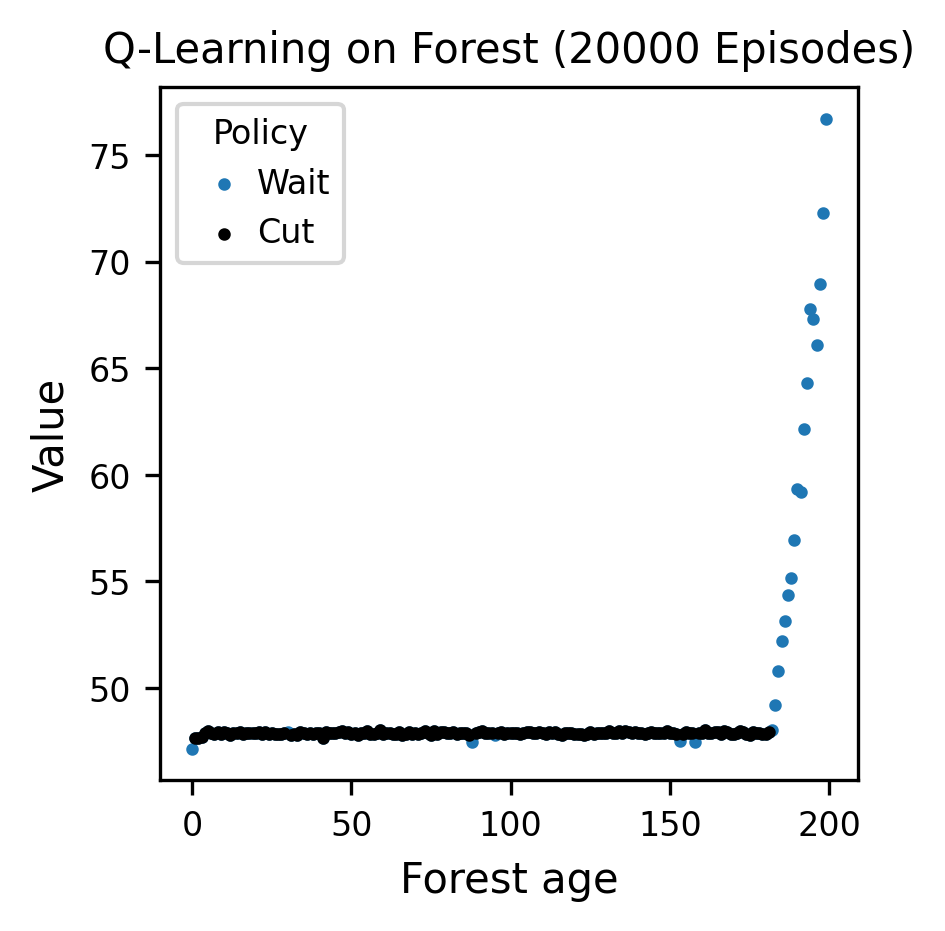

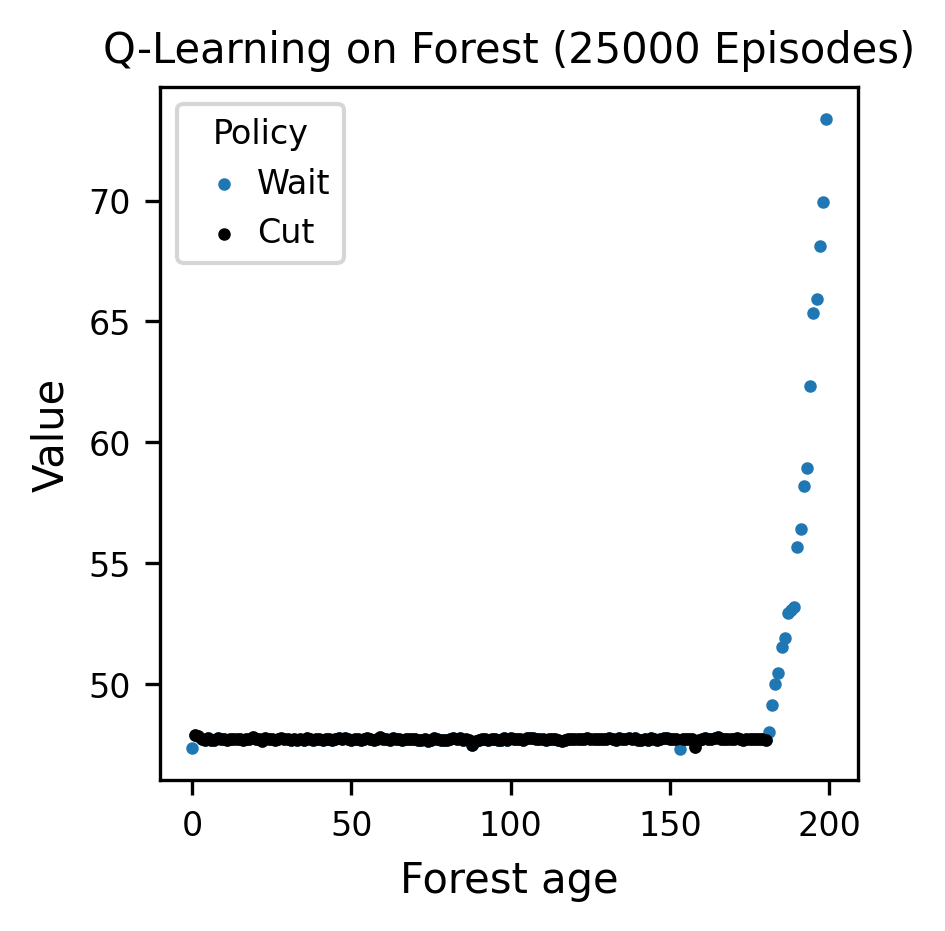

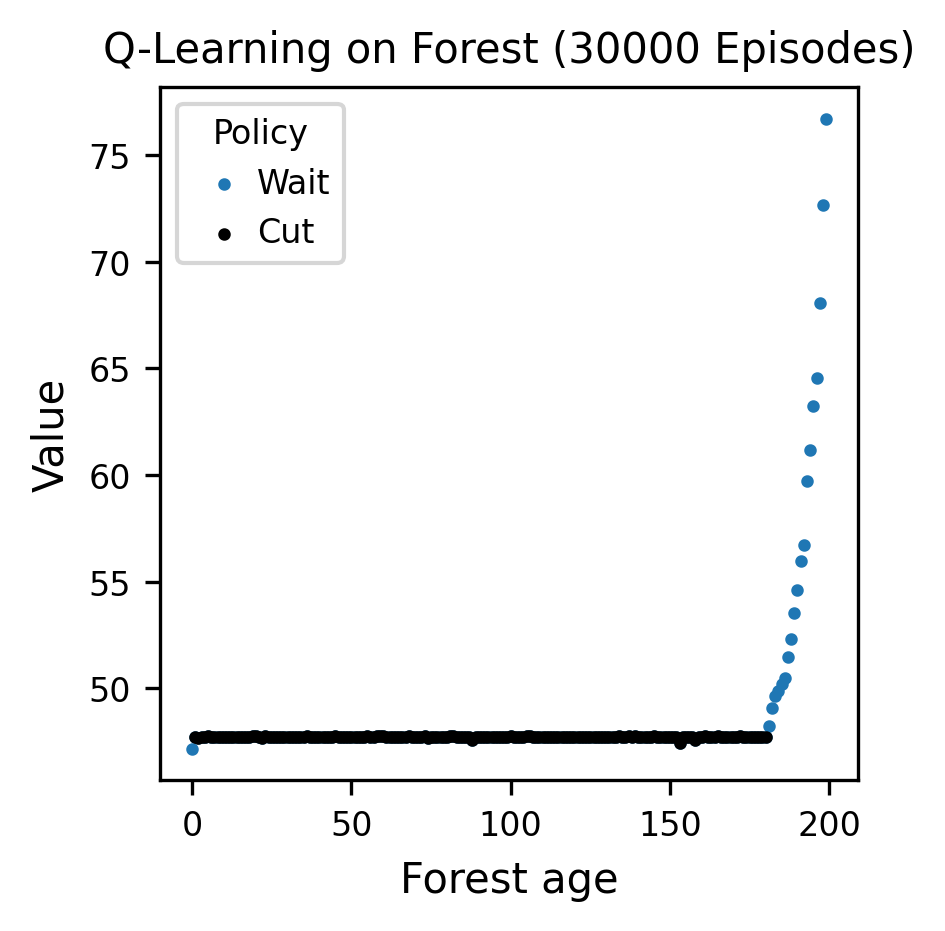

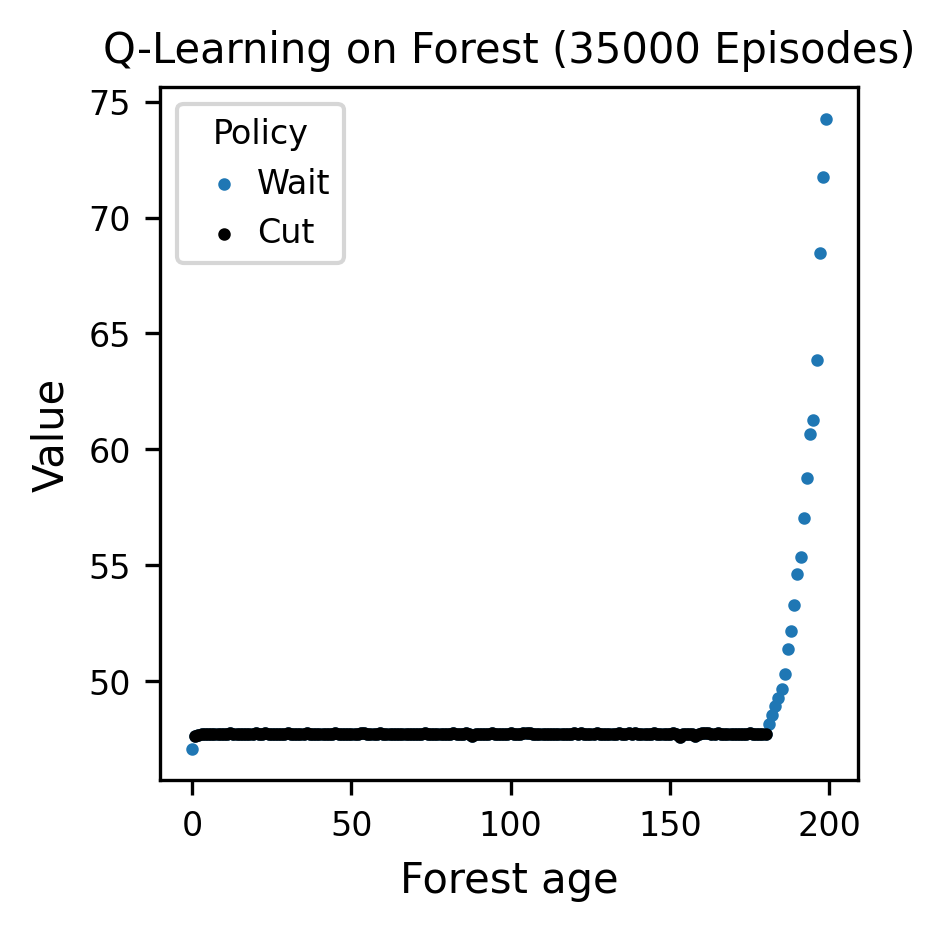

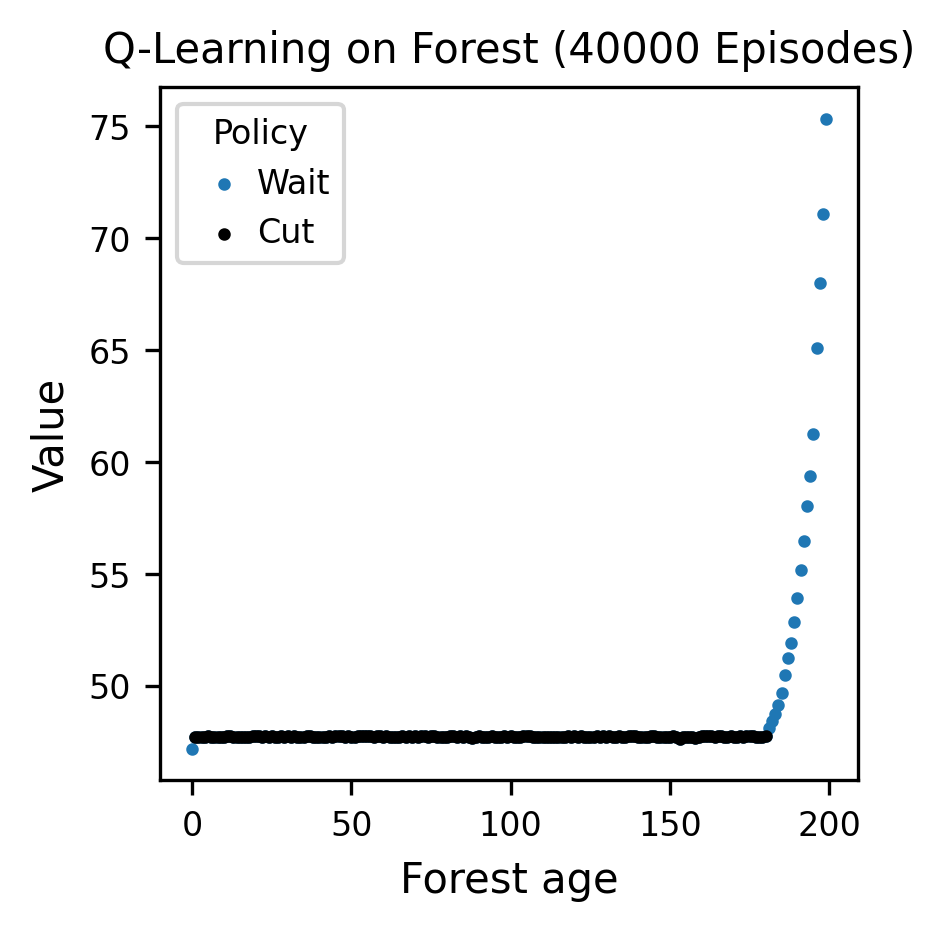

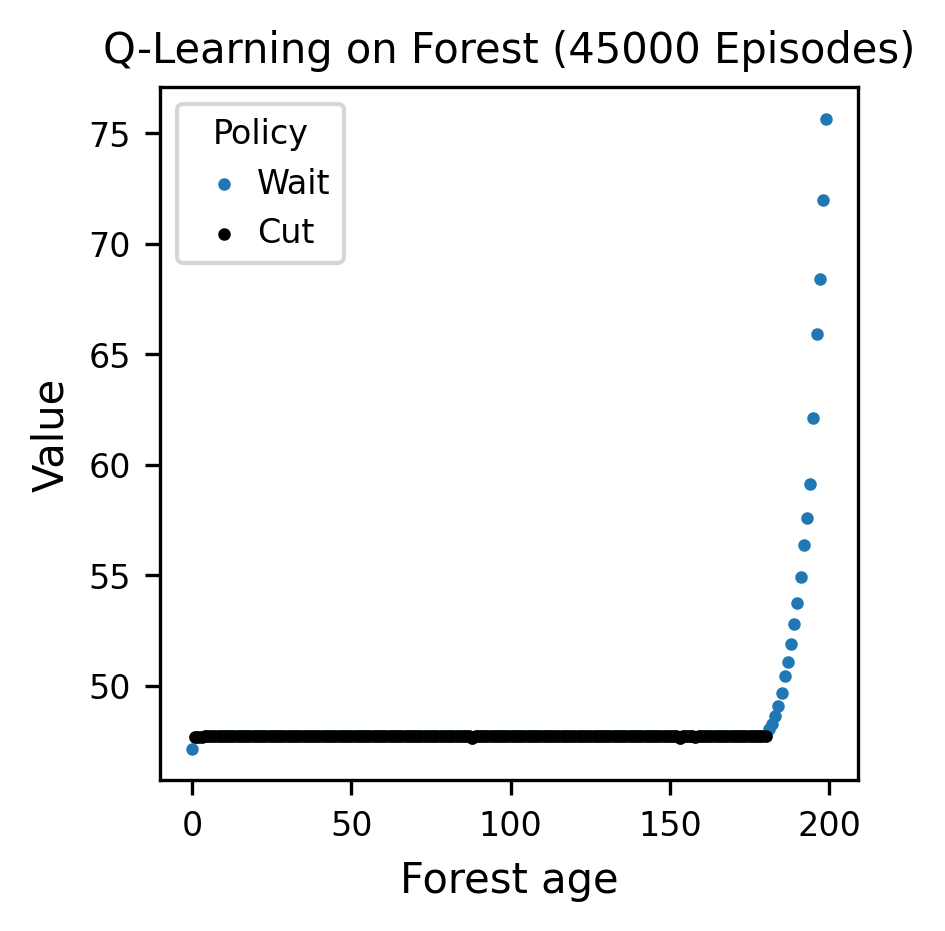

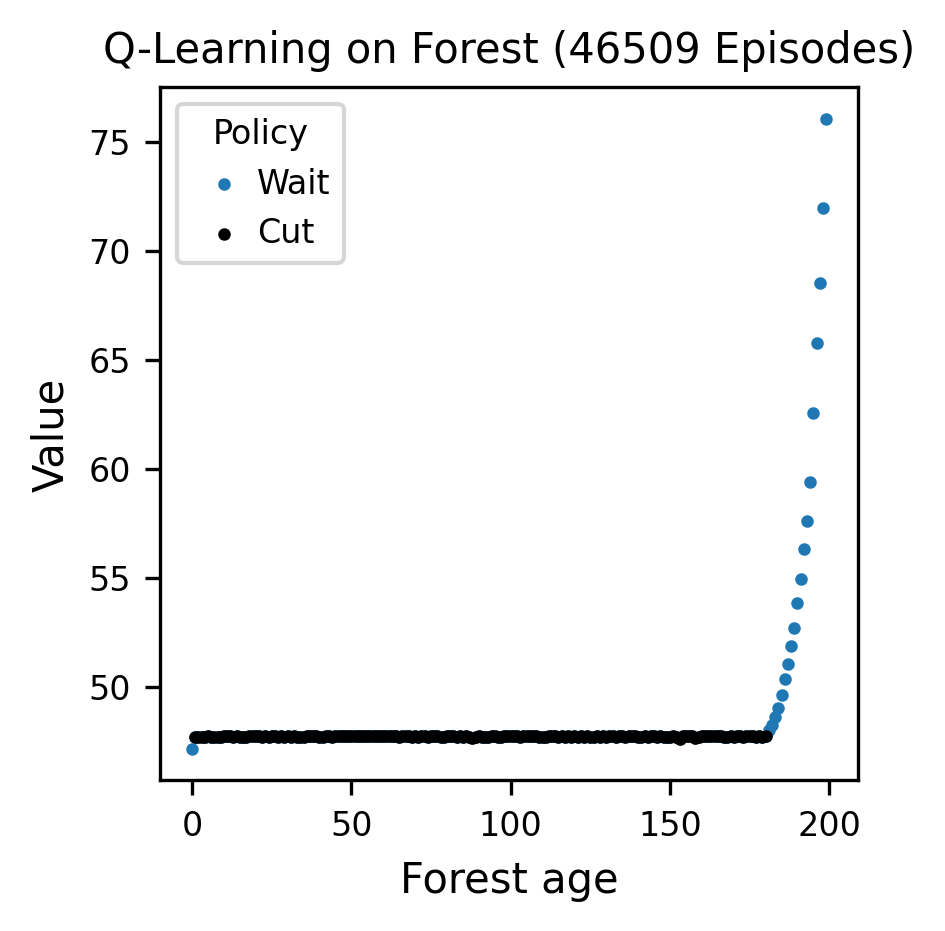

0.004776436869944179 0.2


In [206]:
np.random.seed(RANDOM_STATE)
q=MyQLearning(P,R,0.99,n_iter=1000000,epsilon_min=0.2,epsilon=0.2,alpha_min=0.001,alpha=0.5,alpha_decay=0.99999,epsilon_decay=0.9)
q.Q[:,:]=np.random.randint(q.S,size=(q.S,2))
q_run_stats=q.run(plot=True,plot_freq=5000,episode_length=10)
print(q.alpha,q.epsilon)

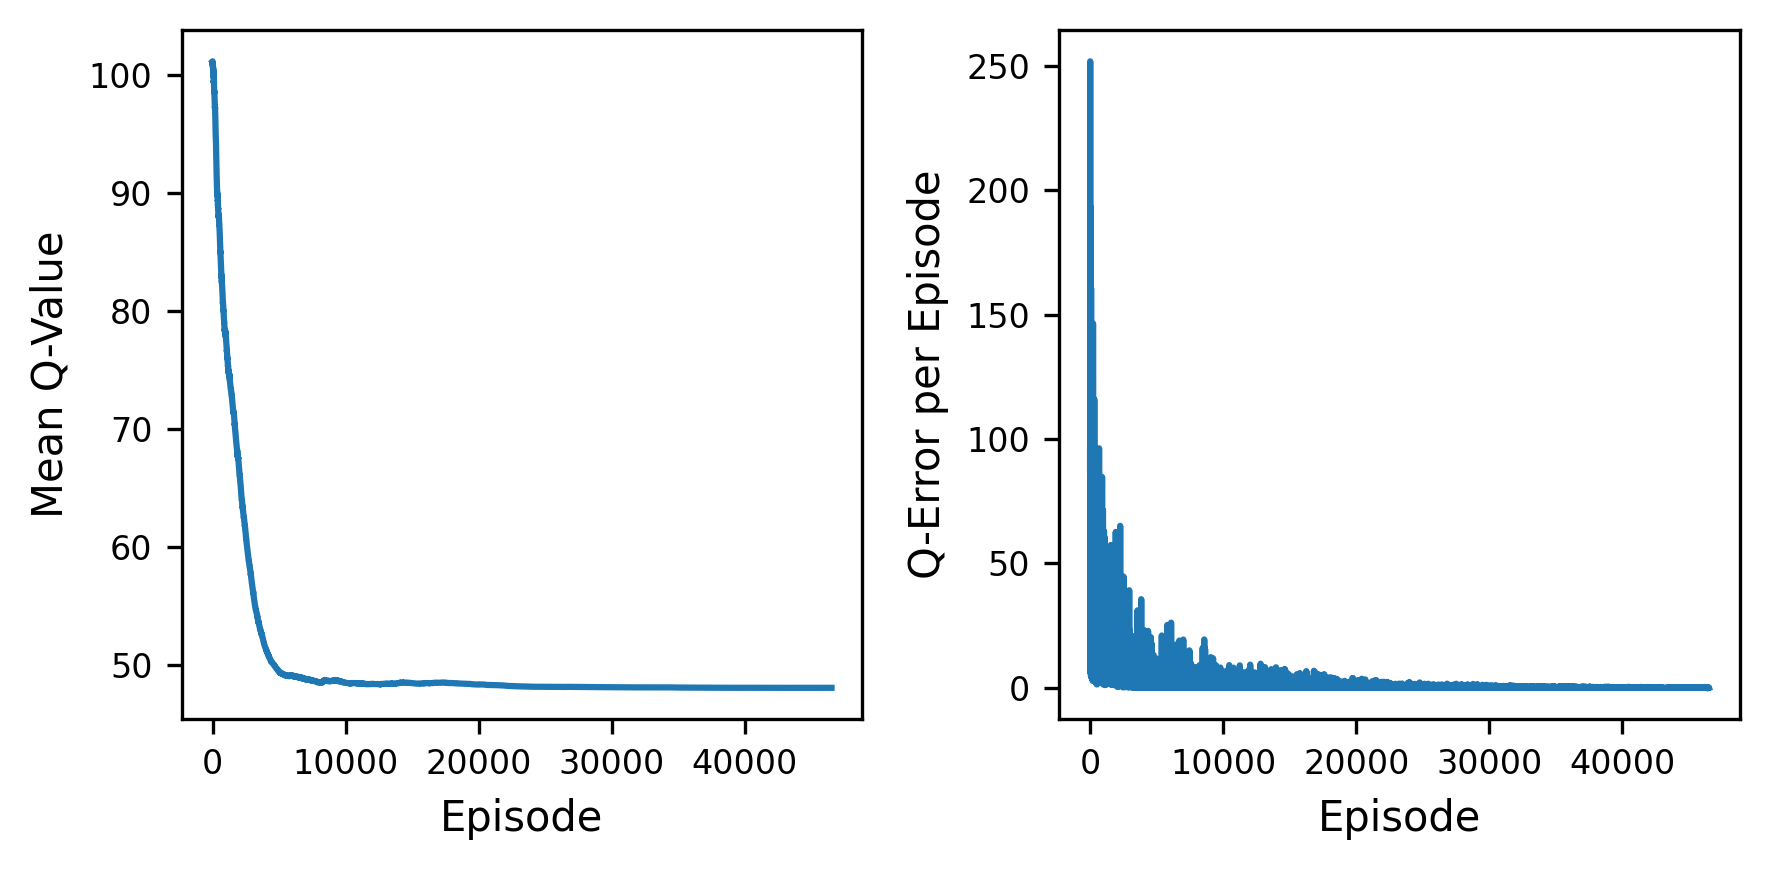

In [197]:

fig,axs=plt.subplots(1,2,figsize=(6,3))

ax=axs[0]

ax.plot(q.episode_mean_Q)

ax.set_xlabel("Episode")

ax.set_ylabel("Mean Q-Value")


ax=axs[1]

ax.plot(q.error_per_episode)
ax.set_xlabel("Episode")
ax.set_ylabel("Q-Error per Episode")

fig.tight_layout()

0.18393962861053045
0.004776436869944179
0.001


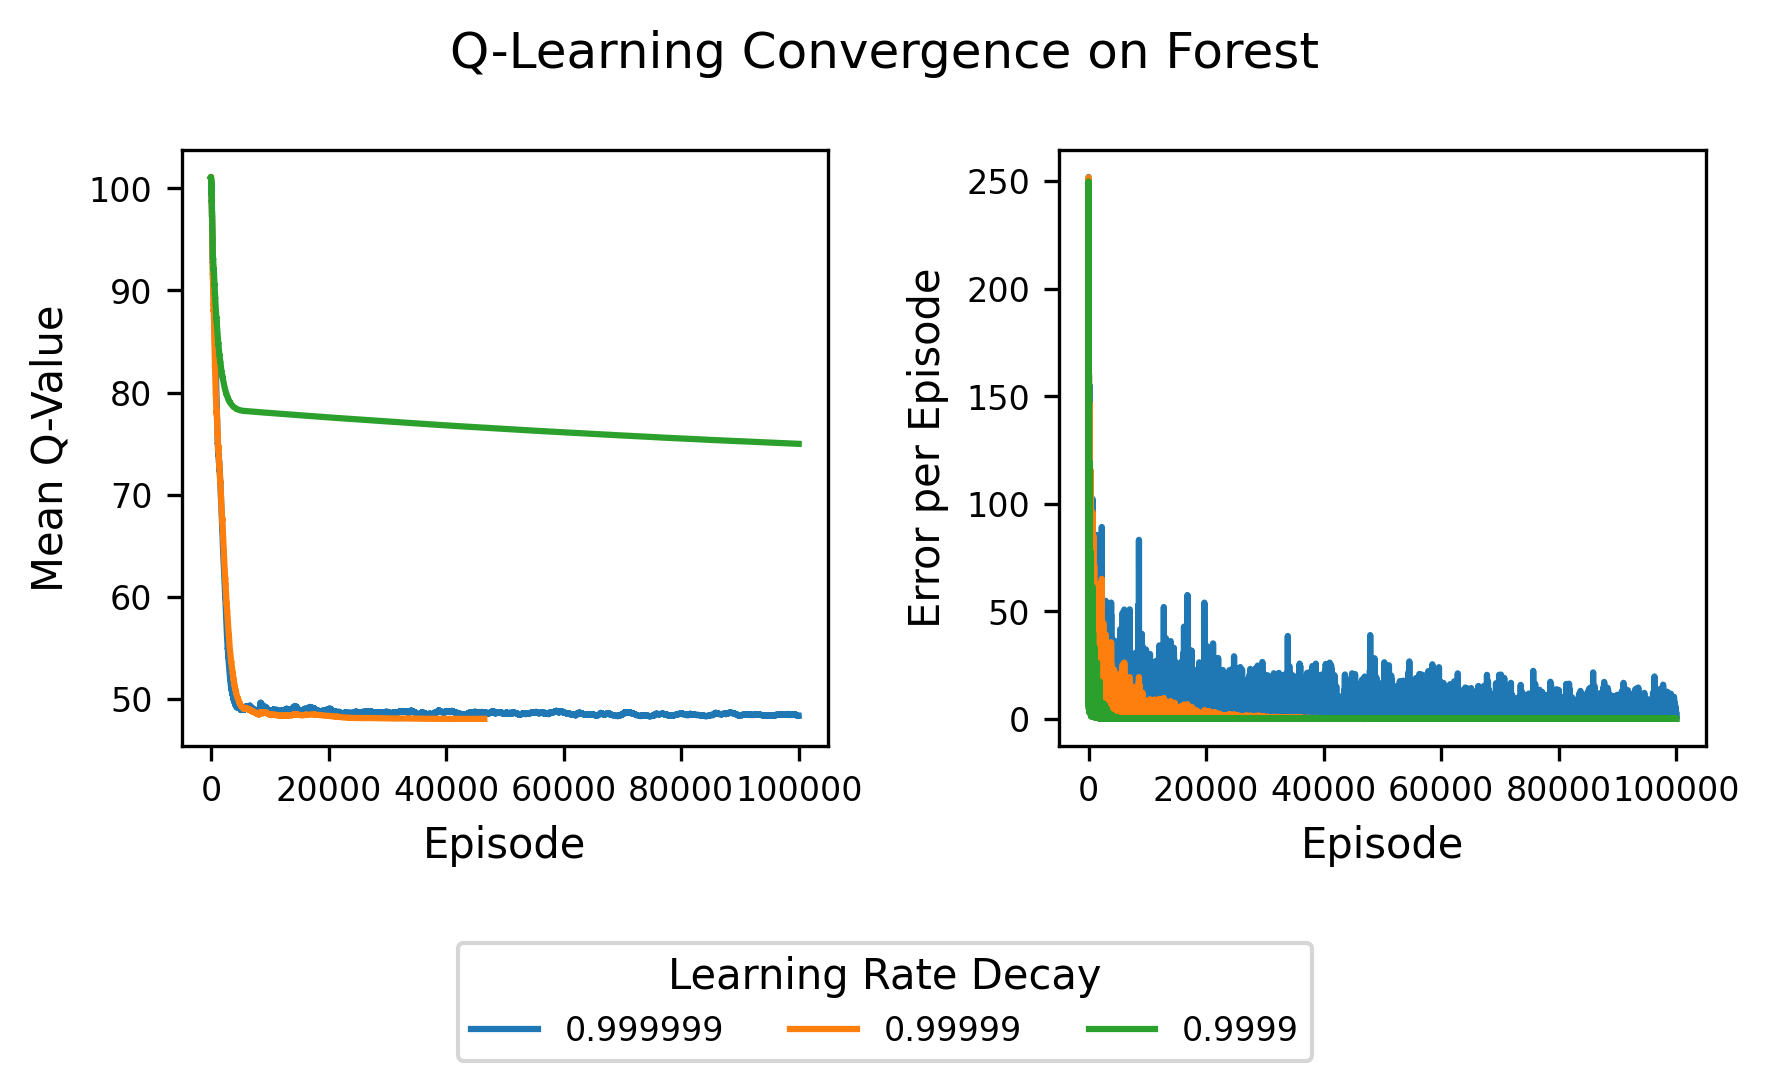

In [195]:

params=[0.999999,0.99999,0.9999]
q_run_stats=[]
run_resets=[]

fig,axs=plt.subplots(1,2,figsize=(6,3))
handles = []
for i,p in enumerate(params):
    np.random.seed(RANDOM_STATE)
    _q=MyQLearning(P,R,0.99,n_iter=1000000,epsilon_min=0.2,epsilon=0.2,alpha_min=0.001,alpha=0.5,alpha_decay=p,epsilon_decay=0.9)
    _q.Q[:,:]=np.random.randint(_q.S,size=(_q.S,2))
    _q_run_stats=_q.run(plot=False,plot_freq=100000,episode_length=10)
    print(_q.alpha)



    ax=axs[0]

    handles.append(ax.plot(_q.episode_mean_Q,label=p)[0])

    ax.set_xlabel("Episode")
    ax.set_ylabel("Mean Q-Value")

    ax=axs[1]

    ax.plot(_q.error_per_episode,label=p)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Error per Episode")
    fig.tight_layout()

fig.suptitle("Q-Learning Convergence on Forest")
fig.tight_layout()


fig.legend(handles, params, bbox_to_anchor=(0.5, -0.1),ncol=len(handles),loc='center',title="Learning Rate Decay")


0.004217227607987235
0.004776436869944179
0.004178732726063286


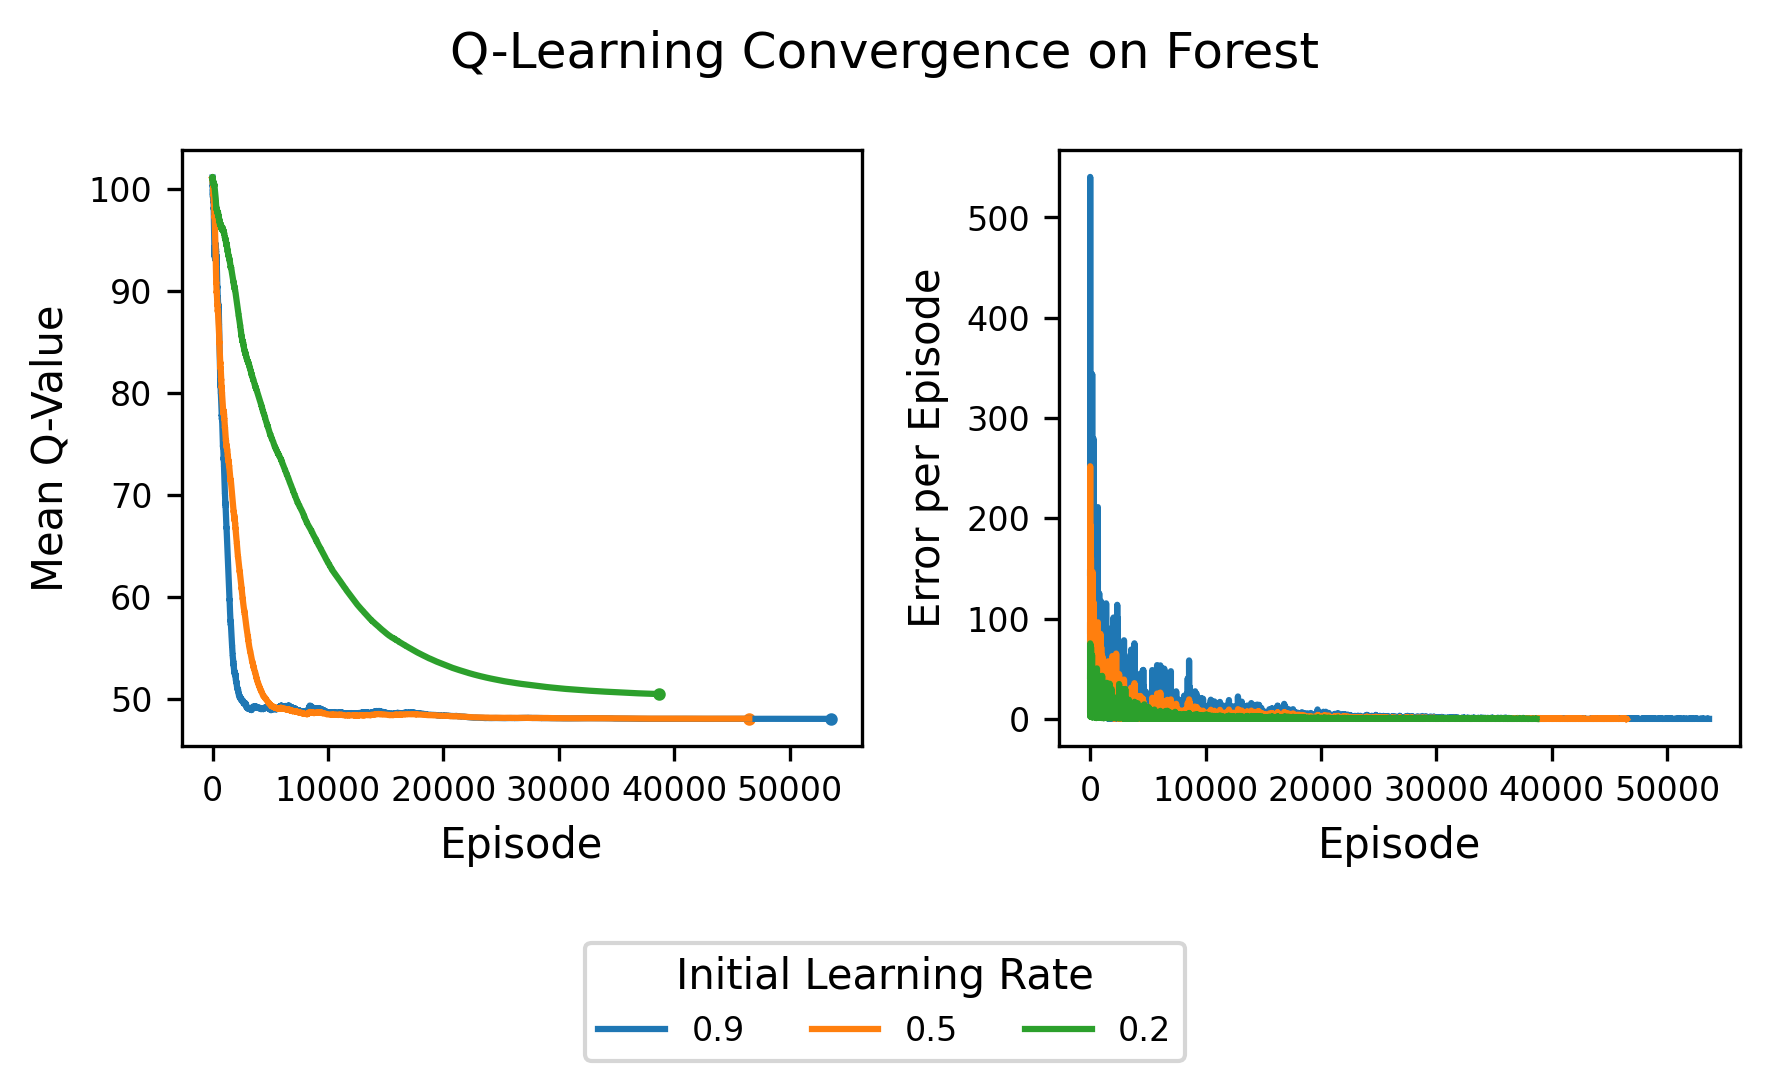

In [192]:

params=[0.9,0.5,0.2]
q_run_stats=[]
run_resets=[]

fig,axs=plt.subplots(1,2,figsize=(6,3))
handles = []
for i,p in enumerate(params):
    np.random.seed(RANDOM_STATE)
    _q=MyQLearning(P,R,0.99,n_iter=1000000,epsilon_min=0.2,epsilon=0.2,alpha_min=0.001,alpha=p,alpha_decay=0.99999,epsilon_decay=0.9)
    _q.Q[:,:]=np.random.randint(_q.S,size=(_q.S,2))
    _q_run_stats=_q.run(plot=False,plot_freq=100000,episode_length=10)
    print(_q.alpha)



    ax=axs[0]

    handles.append(ax.plot(_q.episode_mean_Q,label=p)[0])
    ax.scatter(len(_q.episode_mean_Q)-1,_q.episode_mean_Q[-1])

    ax.set_xlabel("Episode")
    ax.set_ylabel("Mean Q-Value")

    ax=axs[1]

    ax.plot(_q.error_per_episode,label=p)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Error per Episode")
    fig.tight_layout()

fig.suptitle("Q-Learning Convergence on Forest")
fig.tight_layout()


fig.legend(handles, params, bbox_to_anchor=(0.5, -0.1),ncol=len(handles),loc='center',title="Initial Learning Rate")


In [207]:
for run_stats in [vi_run_stats,pi_run_stats,q_run_stats]:
    print(run_stats[-1]['Time']*1000)

25.888681411743164
33.86807441711426
8395.281076431274
